# Amharic Character Recognition With VIT


### Importing Libraries


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import math
from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'Abyssinica SIL' 


In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


### Loading and Preprocessing Data


In [4]:
class AmharicDataset(Dataset):
    """
    Dataset class for Amharic character recognition
    """
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {}
        self.idx_to_class = {}
        
        # Load all images and labels
        self._load_dataset()
    
    def _load_dataset(self):
        """Load images from dataset directory structure"""
        # Get all subdirectories (classes)
        classes = sorted(os.listdir(self.dataset_path))
        
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(self.dataset_path, class_name)
            
            # Skip if not a directory
            if not os.path.isdir(class_dir):
                continue
                
            # Map class name to integer
            self.label_map[class_name] = i
            self.idx_to_class[i] = class_name
            
            # Load images from this class
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                
                # Skip non-image files
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                
                # Store image path and label
                self.images.append(img_path)
                self.labels.append(i)
        
        print(f"Loaded {len(self.images)} images with {len(self.label_map)} classes")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load and preprocess image
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.resize(img, (224, 224))  # Resize for ViT (typically 224x224 for vision transformers)
        
        # Convert to tensor - for grayscale, repeat to get 3 channels for ViT
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        img = np.stack([img, img, img], axis=0)  # Create 3 channels [3, 224, 224]
        img = torch.from_numpy(img)  
        
        # Apply additional transforms if specified
        if self.transform:
            img = self.transform(img)
        
        return img, label
    
    def get_class_info(self):
        return self.label_map, self.idx_to_class


### Model Architecture


In [5]:
class PatchEmbedding(nn.Module):
    """
    Split image into patches and embed them
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Linear projection
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
    
    def forward(self, x):
        # (batch_size, channels, img_size, img_size) -> (batch_size, embed_dim, n_patches^0.5, n_patches^0.5)
        x = self.proj(x)
        # (batch_size, embed_dim, n_patches^0.5, n_patches^0.5) -> (batch_size, embed_dim, n_patches)
        x = x.flatten(2)
        # (batch_size, embed_dim, n_patches) -> (batch_size, n_patches, embed_dim)
        x = x.transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):
    """
    Multi-head Self-Attention mechanism
    """
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Linear projections
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        
        self.scale = self.head_dim ** -0.5
    
    def forward(self, x):
        batch_size, n_tokens, embed_dim = x.shape
        
        # Linear projection to get query, key, value
        qkv = self.qkv(x)
        qkv = qkv.reshape(batch_size, n_tokens, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, n_tokens, head_dim)
        
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (batch_size, num_heads, n_tokens, head_dim)
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (batch_size, num_heads, n_tokens, n_tokens)
        attn = attn.softmax(dim=-1)
        
        # (batch_size, num_heads, n_tokens, head_dim)
        x = (attn @ v)
        # (batch_size, n_tokens, num_heads, head_dim)
        x = x.transpose(1, 2)
        # (batch_size, n_tokens, embed_dim)
        x = x.reshape(batch_size, n_tokens, embed_dim)
        
        # Final projection
        x = self.proj(x)
        
        return x

class MLP(nn.Module):
    """
    Multi-Layer Perceptron
    """
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),
            out_features=embed_dim,
            dropout=dropout
        )
    
    def forward(self, x):
        # First sublayer: Multi-head attention with residual connection and layer norm
        x = x + self.attn(self.norm1(x))
        # Second sublayer: MLP with residual connection and layer norm
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    """
    Vision Transformer for Amharic character classification
    """
    def __init__(
        self, 
        img_size=224, 
        patch_size=16, 
        in_channels=3, 
        num_classes=147,
        embed_dim=768, 
        depth=12, 
        num_heads=12, 
        mlp_ratio=4.0, 
        dropout=0.1
    ):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size, 
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Number of patches
        num_patches = self.patch_embed.n_patches
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        # Dropout
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            )
            for _ in range(depth)
        ])
        
        # Layer norm
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Patch embedding: (batch_size, 3, img_size, img_size) -> (batch_size, n_patches, embed_dim)
        x = self.patch_embed(x)
        
        # Add class token: (batch_size, n_patches, embed_dim) -> (batch_size, n_patches + 1, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Take only the class token for classification
        x = x[:, 0]
        
        # Classification
        x = self.head(x)
        
        return x
    
# Simplified ViT for faster training and less memory usage
class SimpleVisionTransformer(nn.Module):
    """
    Simplified Vision Transformer for Amharic character classification
    Uses fewer layers and smaller embedding dimensions
    """
    def __init__(
        self, 
        img_size=224, 
        patch_size=16, 
        in_channels=3, 
        num_classes=147,
        embed_dim=384,  # Smaller embedding dimension
        depth=6,        # Fewer transformer layers
        num_heads=6,    # Fewer attention heads
        mlp_ratio=4.0, 
        dropout=0.1
    ):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size, 
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Number of patches
        num_patches = self.patch_embed.n_patches
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Dropout
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            )
            for _ in range(depth)
        ])
        
        # Layer norm
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Patch embedding: (batch_size, 3, img_size, img_size) -> (batch_size, n_patches, embed_dim)
        x = self.patch_embed(x)
        
        # Add class token: (batch_size, n_patches, embed_dim) -> (batch_size, n_patches + 1, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Take only the class token for classification
        x = x[:, 0]
        
        # Classification
        x = self.head(x)
        
        return x

### Training


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    """
    Train the PyTorch model
    """
    # Initialize best validation accuracy
    best_val_acc = 0.0
    best_model_wts = None
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({"loss": loss.item(), "acc": correct/total})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, 'best_amharic_vit_model.pth')
            print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'best_val_acc': best_val_acc
    }
    
    return model, history

def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate model on the provided dataloader
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def test_model(model, test_loader, device, idx_to_class):
    """
    Test model and compute metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.append(inputs.cpu().numpy())
    
    # Combine image batches
    all_images = np.vstack([img for img in all_images])
    
    # Compute accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Find the unique classes actually present in the test data
    unique_labels = np.unique(np.array(all_labels))
    
    # Create a mapping of class indices to names for only those classes present in the test data
    present_class_names = {i: idx_to_class[i] for i in unique_labels if i in idx_to_class}
    class_names = [present_class_names[i] for i in sorted(present_class_names.keys())]
    
    # Print metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Found {len(unique_labels)} unique classes in test data")
    
    try:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, labels=sorted(unique_labels), target_names=class_names))
    except Exception as e:
        print(f"Error generating classification report: {e}")
        print("Falling back to basic accuracy metrics")
    
    try:
        # Create confusion matrix - only for classes actually present in the test data
        plt.figure(figsize=(15, 15))
        cm = confusion_matrix(all_labels, all_preds, labels=sorted(unique_labels))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
    except Exception as e:
        print(f"Error generating confusion matrix: {e}")
    
    return accuracy, all_preds, all_labels, all_images

In [7]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(images, true_labels, pred_labels, idx_to_class, num_samples=25):
    """
    Visualize sample predictions
    """
    # Select random samples
    indices = np.random.choice(range(len(images)), min(num_samples, len(images)), replace=False)
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i+1)
        # Display only the first channel for grayscale images
        plt.imshow(images[idx][0], cmap='gray')
        
        true_label = idx_to_class[true_labels[idx]]
        pred_label = idx_to_class[pred_labels[idx]]
        
        color = 'green' if true_labels[idx] == pred_labels[idx] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Loaded 22761 images with 147 classes
Training set: 15881 samples
Validation set: 3440 samples
Test set: 3440 samples
Using device: cuda:0
SimpleVisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-05, elementwise_a

Epoch 1/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 1/50 => Train Loss: 4.6228, Train Acc: 0.0345, Val Loss: 3.7824, Val Acc: 0.1166
New best model saved with validation accuracy: 0.1166


Epoch 2/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 2/50 => Train Loss: 2.7158, Train Acc: 0.3046, Val Loss: 2.0654, Val Acc: 0.4404
New best model saved with validation accuracy: 0.4404


Epoch 3/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 3/50 => Train Loss: 1.6621, Train Acc: 0.5337, Val Loss: 1.4592, Val Acc: 0.5863
New best model saved with validation accuracy: 0.5863


Epoch 4/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 4/50 => Train Loss: 1.2023, Train Acc: 0.6440, Val Loss: 1.1673, Val Acc: 0.6520
New best model saved with validation accuracy: 0.6520


Epoch 5/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 5/50 => Train Loss: 0.9667, Train Acc: 0.7026, Val Loss: 0.9982, Val Acc: 0.6933
New best model saved with validation accuracy: 0.6933


Epoch 6/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 6/50 => Train Loss: 0.8177, Train Acc: 0.7415, Val Loss: 0.9614, Val Acc: 0.7035
New best model saved with validation accuracy: 0.7035


Epoch 7/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 7/50 => Train Loss: 0.7039, Train Acc: 0.7734, Val Loss: 0.9248, Val Acc: 0.7026


Epoch 8/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 8/50 => Train Loss: 0.6152, Train Acc: 0.7988, Val Loss: 0.8688, Val Acc: 0.7355
New best model saved with validation accuracy: 0.7355


Epoch 9/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 9/50 => Train Loss: 0.5479, Train Acc: 0.8206, Val Loss: 0.8975, Val Acc: 0.7212


Epoch 10/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 10/50 => Train Loss: 0.4885, Train Acc: 0.8352, Val Loss: 0.8185, Val Acc: 0.7500
New best model saved with validation accuracy: 0.7500


Epoch 11/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 11/50 => Train Loss: 0.4246, Train Acc: 0.8563, Val Loss: 0.8376, Val Acc: 0.7451


Epoch 12/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 12/50 => Train Loss: 0.3845, Train Acc: 0.8678, Val Loss: 0.8846, Val Acc: 0.7401


Epoch 13/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 13/50 => Train Loss: 0.3529, Train Acc: 0.8785, Val Loss: 0.8258, Val Acc: 0.7581
New best model saved with validation accuracy: 0.7581


Epoch 14/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 14/50 => Train Loss: 0.3090, Train Acc: 0.8921, Val Loss: 0.8351, Val Acc: 0.7544


Epoch 15/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 15/50 => Train Loss: 0.2887, Train Acc: 0.8982, Val Loss: 0.8796, Val Acc: 0.7465


Epoch 16/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 16/50 => Train Loss: 0.2691, Train Acc: 0.9062, Val Loss: 0.8638, Val Acc: 0.7509


Epoch 17/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 17/50 => Train Loss: 0.1113, Train Acc: 0.9645, Val Loss: 0.7005, Val Acc: 0.7985
New best model saved with validation accuracy: 0.7985


Epoch 18/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 18/50 => Train Loss: 0.0713, Train Acc: 0.9803, Val Loss: 0.6963, Val Acc: 0.8049
New best model saved with validation accuracy: 0.8049


Epoch 19/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 19/50 => Train Loss: 0.0591, Train Acc: 0.9831, Val Loss: 0.7081, Val Acc: 0.8032


Epoch 20/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 20/50 => Train Loss: 0.0515, Train Acc: 0.9843, Val Loss: 0.7373, Val Acc: 0.8067
New best model saved with validation accuracy: 0.8067


Epoch 21/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 21/50 => Train Loss: 0.0459, Train Acc: 0.9856, Val Loss: 0.7422, Val Acc: 0.8041


Epoch 22/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 22/50 => Train Loss: 0.0384, Train Acc: 0.9892, Val Loss: 0.7609, Val Acc: 0.8012


Epoch 23/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 23/50 => Train Loss: 0.0360, Train Acc: 0.9885, Val Loss: 0.7679, Val Acc: 0.8029


Epoch 24/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 24/50 => Train Loss: 0.0330, Train Acc: 0.9869, Val Loss: 0.7867, Val Acc: 0.8032


Epoch 25/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 25/50 => Train Loss: 0.0232, Train Acc: 0.9913, Val Loss: 0.7682, Val Acc: 0.8090
New best model saved with validation accuracy: 0.8090


Epoch 26/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 26/50 => Train Loss: 0.0205, Train Acc: 0.9916, Val Loss: 0.7708, Val Acc: 0.8105
New best model saved with validation accuracy: 0.8105


Epoch 27/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 27/50 => Train Loss: 0.0195, Train Acc: 0.9923, Val Loss: 0.7722, Val Acc: 0.8099


Epoch 28/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 28/50 => Train Loss: 0.0187, Train Acc: 0.9909, Val Loss: 0.7771, Val Acc: 0.8093


Epoch 29/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 29/50 => Train Loss: 0.0182, Train Acc: 0.9909, Val Loss: 0.7845, Val Acc: 0.8087


Epoch 30/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 30/50 => Train Loss: 0.0176, Train Acc: 0.9902, Val Loss: 0.7863, Val Acc: 0.8087


Epoch 31/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 31/50 => Train Loss: 0.0163, Train Acc: 0.9921, Val Loss: 0.7849, Val Acc: 0.8108
New best model saved with validation accuracy: 0.8108


Epoch 32/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 32/50 => Train Loss: 0.0162, Train Acc: 0.9919, Val Loss: 0.7861, Val Acc: 0.8110
New best model saved with validation accuracy: 0.8110


Epoch 33/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 33/50 => Train Loss: 0.0159, Train Acc: 0.9913, Val Loss: 0.7883, Val Acc: 0.8125
New best model saved with validation accuracy: 0.8125


Epoch 34/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 34/50 => Train Loss: 0.0158, Train Acc: 0.9919, Val Loss: 0.7894, Val Acc: 0.8108


Epoch 35/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 35/50 => Train Loss: 0.0159, Train Acc: 0.9912, Val Loss: 0.7893, Val Acc: 0.8093


Epoch 36/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 36/50 => Train Loss: 0.0156, Train Acc: 0.9922, Val Loss: 0.7918, Val Acc: 0.8110


Epoch 37/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 37/50 => Train Loss: 0.0155, Train Acc: 0.9921, Val Loss: 0.7912, Val Acc: 0.8105


Epoch 38/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 38/50 => Train Loss: 0.0154, Train Acc: 0.9929, Val Loss: 0.7909, Val Acc: 0.8110


Epoch 39/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 39/50 => Train Loss: 0.0155, Train Acc: 0.9922, Val Loss: 0.7913, Val Acc: 0.8113


Epoch 40/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 40/50 => Train Loss: 0.0153, Train Acc: 0.9920, Val Loss: 0.7917, Val Acc: 0.8105


Epoch 41/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 41/50 => Train Loss: 0.0153, Train Acc: 0.9919, Val Loss: 0.7915, Val Acc: 0.8108


Epoch 42/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 42/50 => Train Loss: 0.0152, Train Acc: 0.9933, Val Loss: 0.7913, Val Acc: 0.8108


Epoch 43/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 43/50 => Train Loss: 0.0152, Train Acc: 0.9923, Val Loss: 0.7914, Val Acc: 0.8108


Epoch 44/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 44/50 => Train Loss: 0.0152, Train Acc: 0.9924, Val Loss: 0.7915, Val Acc: 0.8110


Epoch 45/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 45/50 => Train Loss: 0.0153, Train Acc: 0.9923, Val Loss: 0.7917, Val Acc: 0.8105


Epoch 46/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 46/50 => Train Loss: 0.0152, Train Acc: 0.9924, Val Loss: 0.7918, Val Acc: 0.8105


Epoch 47/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 47/50 => Train Loss: 0.0153, Train Acc: 0.9929, Val Loss: 0.7918, Val Acc: 0.8105


Epoch 48/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 48/50 => Train Loss: 0.0152, Train Acc: 0.9926, Val Loss: 0.7919, Val Acc: 0.8108


Epoch 49/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 49/50 => Train Loss: 0.0153, Train Acc: 0.9911, Val Loss: 0.7919, Val Acc: 0.8108


Epoch 50/50:   0%|          | 0/993 [00:00<?, ?it/s]

Epoch 50/50 => Train Loss: 0.0153, Train Acc: 0.9916, Val Loss: 0.7919, Val Acc: 0.8108


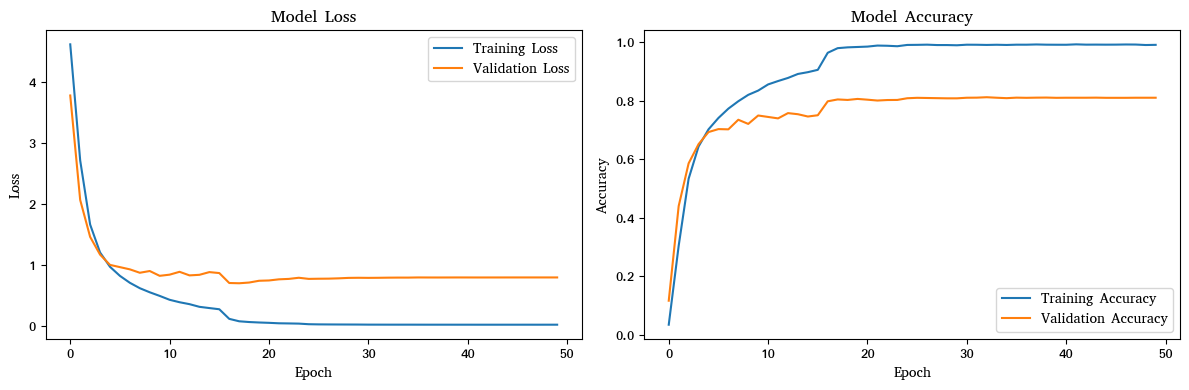

Testing:   0%|          | 0/215 [00:00<?, ?it/s]

Test Accuracy: 0.8125
Found 142 unique classes in test data

Classification Report:
              precision    recall  f1-score   support

           ሀ       0.83      0.92      0.87        26
           ሁ       0.97      1.00      0.99        33
           ሂ       0.86      0.93      0.89        27
           ሃ       0.96      0.82      0.88        28
           ሄ       0.85      0.85      0.85        26
           ህ       1.00      0.89      0.94        27
           ሆ       1.00      0.97      0.98        30
           ለ       0.76      0.62      0.68        21
           ሉ       0.88      0.63      0.73        35
           ሊ       0.65      0.84      0.73        31
           ላ       0.81      0.71      0.76        24
           ሌ       0.68      0.68      0.68        25
           ል       0.93      0.93      0.93        28
           ሎ       0.72      0.88      0.79        24
           ሐ       0.85      0.85      0.85        33
           ሑ       0.90      0.82      0.86        

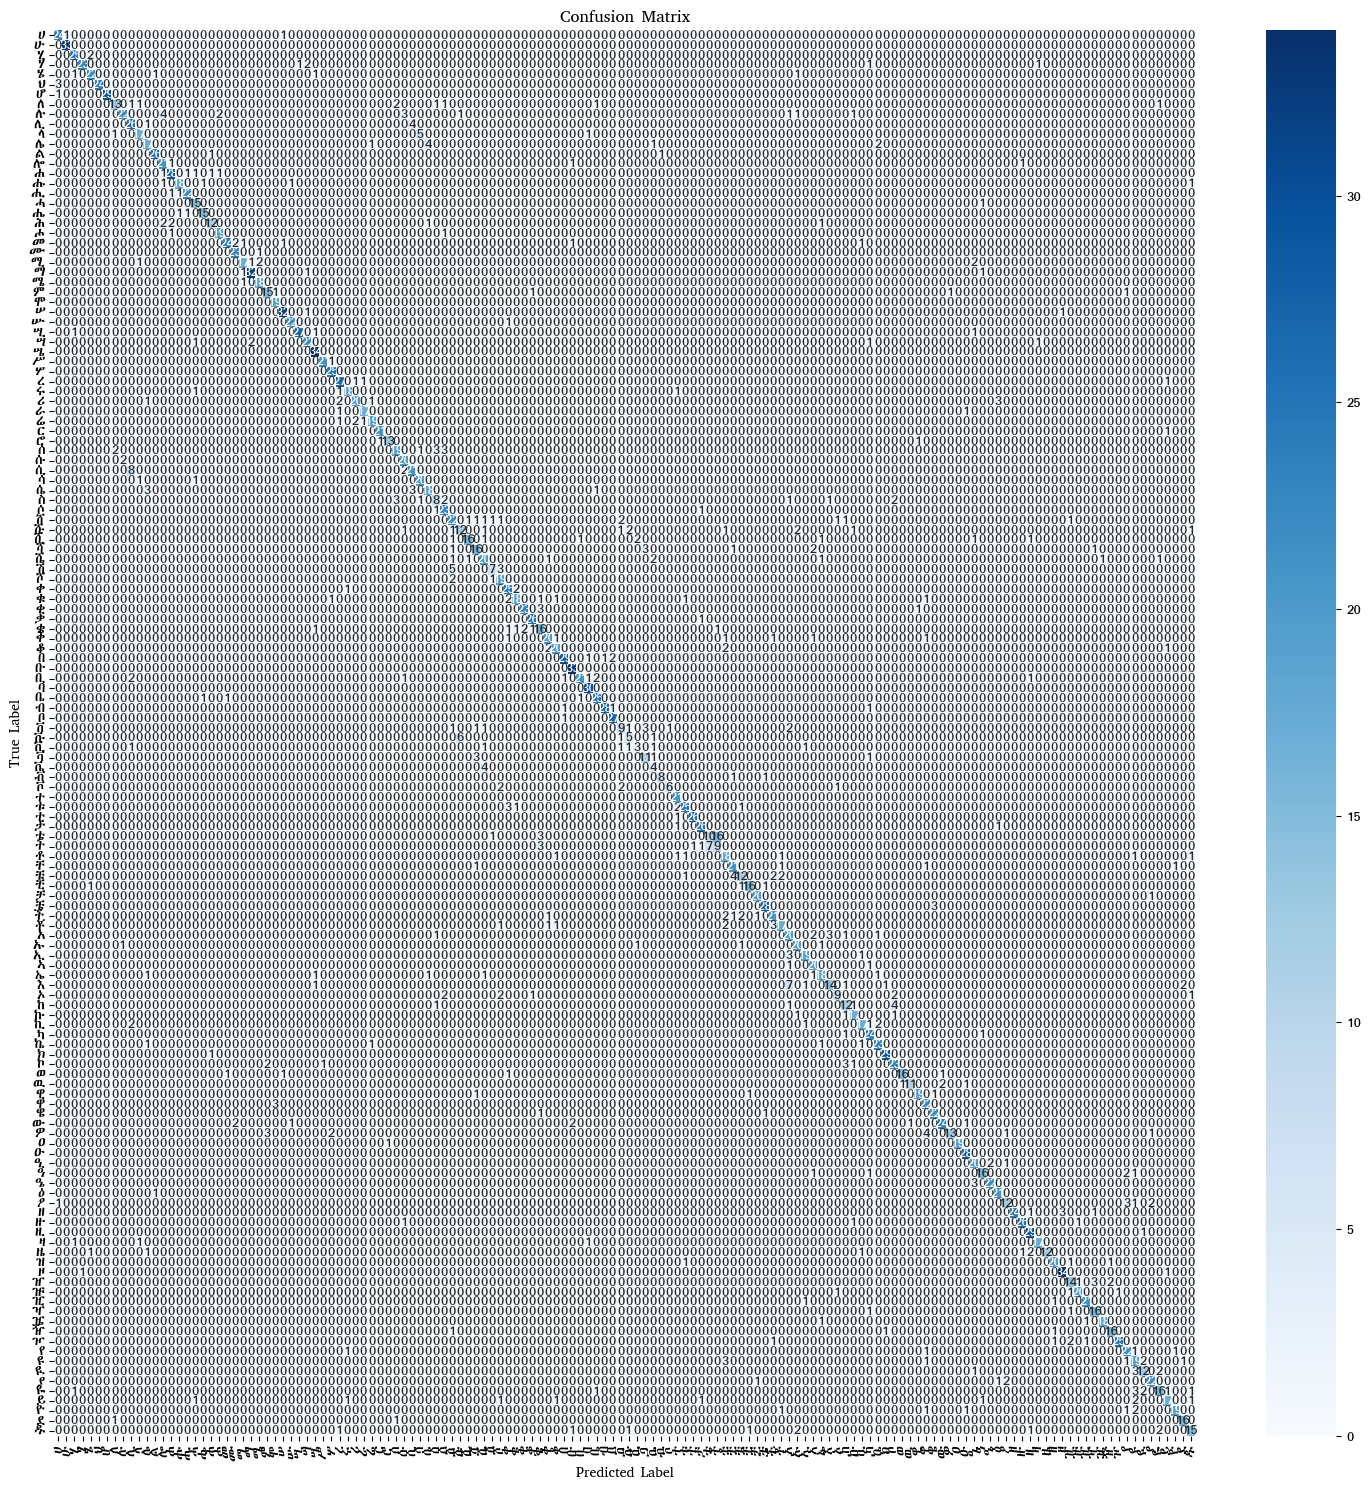

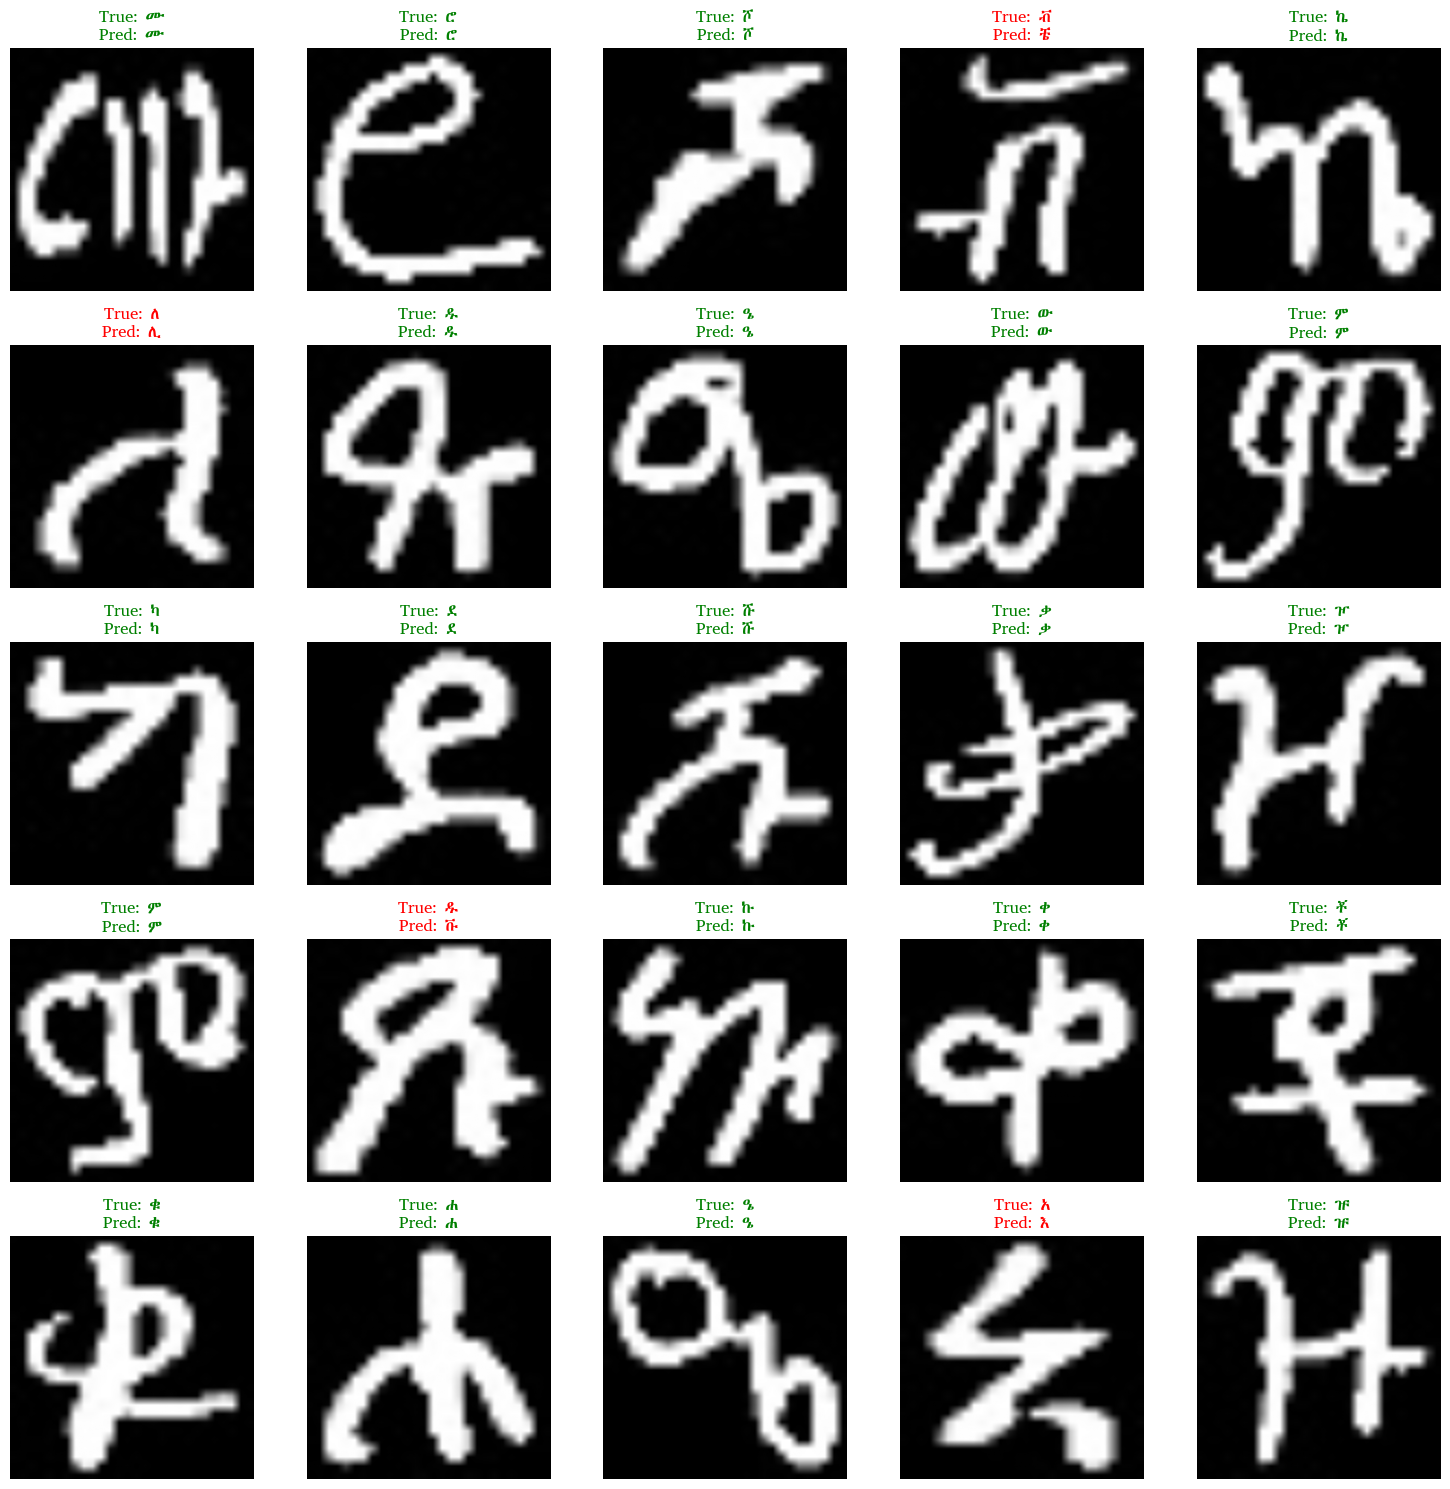

: 

In [11]:
dataset_path = '/home/hailemicaelyimer/Desktop/ACR/dataset'

# Create dataset
full_dataset = AmharicDataset(dataset_path)
label_map, idx_to_class = full_dataset.get_class_info()
num_classes = len(label_map)

# Create indices for each class to ensure stratified sampling
class_indices = {}
for i, label in enumerate(full_dataset.labels):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

# Split indices for each class
train_indices, val_test_indices = [], []
for label, indices in class_indices.items():
    # Using sklearn's train_test_split for stratified splitting within each class
    train_idx, val_test_idx = train_test_split(indices, test_size=0.3, random_state=42)
    train_indices.extend(train_idx)
    val_test_indices.extend(val_test_idx)

# Further split validation and test sets
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=42)

# Create subset datasets
from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create data loaders
batch_size = 16  # Smaller batch size for ViT due to memory requirements
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

# Set device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create Vision Transformer model - using simplified version for faster training
model = SimpleVisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=num_classes,
    embed_dim=384,  # Smaller embedding
    depth=6,        # Fewer layers
    num_heads=6     # Fewer attention heads
)
model = model.to(device)
print(model)

# Add weight decay to certain parameters but exclude bias and layer norm
param_groups = [
    {'params': [p for n, p in model.named_parameters() if 'norm' not in n and 'bias' not in n], 'weight_decay': 0.1},
    {'params': [p for n, p in model.named_parameters() if 'norm' in n or 'bias' in n], 'weight_decay': 0.0}
]

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(param_groups, lr=0.0001, betas=(0.9, 0.999), eps=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=5, verbose=True
)

# Train model
num_epochs = 50  # Reduced epochs for demonstration
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs
)

# Plot training history
plot_training_history(history)

# Test model
accuracy, all_preds, all_labels, all_images = test_model(model, test_loader, device, idx_to_class)

# Visualize predictions
visualize_predictions(all_images, all_labels, all_preds, idx_to_class)

# Save class mappings for future use
import json
with open('amharic_class_mapping.json', 'w', encoding='utf-8') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)